## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [86]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df1 = pd.read_csv("ab_data.csv")
df1.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df1.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df1.nunique()["user_id"]

290584

d. The proportion of users converted.

In [6]:
df1.query("converted == 1").shape[0]/df1.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [13]:
df1.query('(landing_page=="new_page" and group!="treatment") or (landing_page!="new_page" and group=="treatment")').shape[0]

3893

f. Do any of the rows have missing values?

In [16]:
df1.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

There are no rows with missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [18]:
# drop the unnecessary rows
df2 = df1.drop(df1.query('(landing_page=="new_page" and group!="treatment") or (landing_page!="new_page" and group=="treatment")').index)

In [19]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [20]:
df2.nunique()["user_id"]

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [22]:
df2['user_id'].duplicated().sum()

1

c. What is the row information for the repeat **user_id**? 

In [23]:
df2.loc[df2[df2.user_id.duplicated()].index]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [24]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

Check That There is No Duplicated user_id in df2

In [25]:
df2.user_id.duplicated().sum()

0

There is No Duplicated user_id in df2


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [26]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [27]:
p_control = df2[df2['group'] == 'control']['converted'].mean()
p_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [28]:
p_treatment = df2[df2['group'] == 'treatment']['converted'].mean()
p_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [29]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Answer:**

In the final dataset, the number of users landing on new page and old page is almost the same with 50% each.

Control group has a slightly higher rate of conversion (12.04%) compared to the treatment group (11.88%).

With consideration to the difference between results, we can see that there is not sufficient evidence to say that the treatment page leads to more conversions as the probability of conversion for the treatment group is less than that for the control group.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**

Our alternative hypothesis is what we want to prove to be true, in this case, that the new page is better than the old page. And, the null hypothesis is what we assume to be true before analyzing data, which is that the new page has conversion rate that is less than or equal to that of the old page.

**The Hypothesis will be as follow:**
1. $H_{0}$ : $P_{new}$ =< $P_{old}$ ($P_{new}$ - $P_{old}$ =< 0)
2. $H_{1}$ : $P_{new}$ > $P_{old}$ ($P_{new}$ - $P_{old}$ > 0)

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [30]:
p_new = df2.query("converted == 1").shape[0]/df2.shape[0]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [31]:
p_old = df2.query("converted == 1").shape[0]/df2.shape[0]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [32]:
n_new = df2.query("group == 'treatment'").shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [33]:
n_old = df2.query("group == 'control'").shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [42]:
new_page_converted = np.random.choice([1,0], p=[p_new, 1-p_new], size=n_new)
new_page_converted.mean()

0.11809235427706283

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [47]:
old_page_converted = np.random.choice([1,0], p=[p_old, 1-p_old], size=n_old)
old_page_converted.mean()

0.12058592728223907

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [48]:
diff_page_converted = new_page_converted.mean() - old_page_converted.mean()
diff_page_converted

-0.0024935730051762472

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [ ]:
p_diffs = []
for _ in range (10000):
    new_page_converted = np.random.choice([0,1],size=n_new,p=[(1-p_new),p_new])
    old_page_converted = np.random.choice([0,1],size=n_old,p=[(1-p_old),p_old])
    p_diff = (new_page_converted.sum()/n_new) - (old_page_converted.sum()/n_old)
    p_diffs.append(p_diff)
p_diffs = np.array(p_diffs)
p_diff

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

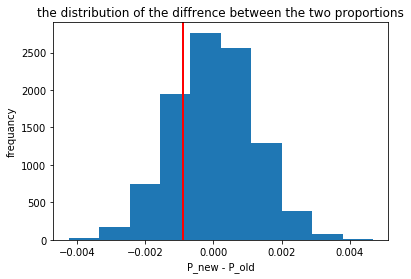

In [90]:
plt.hist(p_diffs)
plt.title('the distribution of the diffrence between the two proportions')
plt.xlabel('P_new - P_old')
plt.ylabel('frequancy')
plt.axvline(x=diff_page_converted, color='red', linewidth=2, label='mean of absolute data difference');

>In this plot, the distibution is norrmally distributed, here we plotted the diffrences in means between the converted rates for old page and new page, by generating random samples using sampling distribution.The red line shows the difference betwwen the means.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [91]:
#calculate the actual diffrence in the data set
actual_diff = p_treatment - p_control
#fit the p-value which is the probability of the
#observing statistic if the null hypothesis is true 
(p_diffs > actual_diff).mean()

0.90639999999999998

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:**

#####  In part j, we have computed the probability of the observing statistic if the null hypothesis is true, this value is called the P-value.
>this value means that if it is high ,the old page's performance is better than the new page or the same,and if it is very low (less than the type I error threshold), the new page's performance is better than the old one.

##### we find that the p-value equals to 0.911 which is high enough and more than .05(Alpha value), so we fail to reject the null hypothesis, and make a decision that the old page's performance is better than or the same as the new page's performance.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [92]:
import statsmodels.api as sm

convert_old = df1.query('group == "control" and converted == 1').shape[0]
convert_new = df1.query('group == "treatment" and converted == 1').shape[0]
n_old = df1.query('group == "control"').shape[0]
n_new = df1.query('group == "treatment"').shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [96]:
#the first parameter is the number of successes and the second is the number of trials
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new],alternative = 'smaller')
z_score,p_value

(1.2369217547321678, 0.89194193365121244)

>#### In the code above, i have used the alternative parameter equals to smaller, smaller means that the alternative hypothesis is p1<p2,where p1 is the proportion of the old page and p2 of the new page.

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**

we want first to calculate the percentage of the z-score using cdf function which is the short of Cumulative density function , and then the critical value at 5% type I error rate using ppf function which is the short of Percent point function.




In [97]:
from scipy.stats import norm

print(norm.cdf(z_score))
 # Tells us the percentage of the significance of z-score is

print(norm.ppf(1-0.05))
 # Tells us what our critical value at 95% confidence is,
 #that the type I error rate equal to 5%

0.891941933651
1.64485362695


In the z-test hypothesis testing, we calculate the critical value and the z-score to see wether the z-score is less than or more than the critical value,that if the z-score is less than the critical value means that we fail to reject the null hypothesis, anf if it is more than the critical value means we can reject the null hypothesis , in our status here we see that the z-score is less than the critical value, which means we fail to reject the null hypothesis and make a decision that the old page's converted rate is better than or equal to the new page's converted rate

#### We see that the findings in this part agree with the findings in parts j and k .

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### We are going to use Logistic regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [98]:
import statsmodels.api as sm
#define the intercept column in the data frame
df2['intercept'] = 1
# create a dummy variable
df2['ab_page'] = pd.get_dummies(df1['landing_page'])['new_page']
df2.tail()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0,1,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0,1,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0,1,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0,1,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [99]:
import statsmodels.api as sm

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [108]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-12 00:00 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [102]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

>The interpreting of this model is if the individual uses the new page, it is 0.985 times more likely to make a conversion than if he uses the old page. which means that there is a very tiny diffrence in the performance between the both pages, with more a little bit in the old page.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### The p-value associated with `ab_page` is `0.1899`. It's smaller than the one calculated earlier `0.90)`. The difference is due to the fact that in part II, we performed a one-sided test, whereas in the logistic regression part, it is two-sided test.

#### The null hypothesis in our logistic regression model argues that there is no relationship among the dependent and independent variables. In this case, we would state that the conversion is not related to the page that was shown `(new page)` to the user. The alternative would suggest that there is a relation between the page showed `(new page)` to the user and the conversion. So that the new page would lead to higher conversions.


>$H_{0}$ : $P_{new}$ - $P_{old}$ = 0

>$H_{1}$ : $P_{new}$ - $P_{old}$ != 0


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**

Many things might effect if a person would convert or not.Gender, location, age and even the day of the experiment might effect our results (for example if we are selling something, few days after the payday, we might have more sales).

It's a good idea to add other factors to our model as they might affect the conversion. There is a disadvantage in case the other variables are correlated with the present variables in the model, then our results may alter or wrong.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [109]:
countries_df = pd.read_csv('countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [116]:
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [117]:
df4 = pd.merge(df2, df_countries, how='inner', on=['user_id'])
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [118]:
df4.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [119]:
### Creating the necessary dummy variables
countries = pd.get_dummies(df4['country'])
df4[['CA', 'UK', 'US']] = countries
df4.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1


In [120]:
print(df4['US'].sum())
print(df4['UK'].sum())
print(df4['CA'].sum())

203619
72466
14499


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [121]:
model_new = sm.Logit(df4['converted'], df4[['intercept','ab_page','US','UK']])
results_new = model_new.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [123]:
results_new.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-12 00:18 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [124]:
df4.groupby(['country','group'])['converted'].mean()

country  group    
CA       control      0.118783
         treatment    0.111902
UK       control      0.120022
         treatment    0.121171
US       control      0.120630
         treatment    0.118466
Name: converted, dtype: float64

>All p-values are higher than 5% here meaning statistically there is nothing significant to reject the null hypothesis. Country and landing page does not seem to change the user behaviour.

#### Let's add additional columns to check.

In [126]:
df4['ab_page_US'] = df4['ab_page']*df4['US']
df4['ab_page_UK'] = df4['ab_page']*df4['UK']

model_most_new = sm.Logit(df4['converted'], df4[['intercept','ab_page','US','UK','ab_page_US','ab_page_UK']])
results_most_new = model_most_new.fit()
results_most_new.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-12 00:23 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
ab_page_US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
ab_page_UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

Once again we couldn't find anything significant to reject our null hypothesis.

## Conclusions
In this project, we have used three ways to know which page has the highest performace with regarding to the convertion rate. the three methods are the probability, hypothesis testing and the regression models.All of these ways gave us an evidences that the performace of the old page is better than the new one but with a tiny diffrence, so we can make a decision to keep the old page and reject the new one.

## References

1.http://www.statsmodels.org/dev/gettingstarted.html

2.https://www.theanalysisfactor.com/interaction-dummy-variables-in-linear-regression/

3.http://www.cantab.net/users/filimon/cursoFCDEF/will/logistic_interact.pdf

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [128]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0